Plots win rate vs. varying adversary/victim visits.

In [80]:
%load_ext autoreload
%autoreload 2
import re

import matplotlib
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

import utils

# To save space in the body of our paper, we're shrinking
# the height of the plots in this notebook.
FIG_HEIGHT_MULTIPLIER = 0.7

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("2-col-neurips"),
        utils.get_style("small-legend"),
        {
            "ytick.minor.visible": True,
            "ytick.left": True, 
            "ytick.right": True,
        },
    ]
)
utils.import_plt_sty("robustness-macros.sty")
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

def force_minor_ticks(ax: matplotlib.axes.Axes) -> None:
    """Force minor ticks to show on a plot."""
    # https://stackoverflow.com/a/73094650/1337463
    ax.xaxis.set_major_locator(matplotlib.ticker.LogLocator(numticks=999))
    ax.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# saved figures for combining into one plot later.
visits_figs = [None for _ in range(3)]

In [91]:
def filter_df_for_player(df: pd.DataFrame, player_substring: str):
    """Get df rows matching a player substring."""
    return df[(df['b_name'].str.contains(player_substring)) | (df['w_name'].str.contains(player_substring))].copy()

def get_adv_win_grouped_by_victim_visits(
    df: pd.DataFrame,
    # default query returns everything
    df_query: str = 'index == index or index != index',
    alpha: float = 0.05,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    """
    Get the adversary win rate grouped by victim visits.

    Returns: (mean, lower bound, upper bound)
    """
    gb = df.query(df_query).groupby("victim_visits")

    adv_win_proportion = gb.adv_win.mean()
    adv_win_lo, adv_win_hi = proportion_confint(
        gb.adv_win.sum(), gb.adv_win.count(), alpha=alpha, method="beta"
    )

    return 100 * adv_win_proportion, 100 * adv_win_lo, 100 * adv_win_hi

def plot_victim_visit_sweep(
    dfs: list[tuple[pd.DataFrame, str]],
    victim_label: str,
    custom_ylabel: str | None = None,
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    """Plot performance of A-MCTS-{R,S++} vs. varying victim visits.

    Args:
        dfs: Dataframes of games paired with a label for each dataframe.
        victim_label: The label to give the victim on the plot.
    """
    fig, ax = plt.subplots(1, 1)

    for df, label in dfs:
        m, l, h = get_adv_win_grouped_by_victim_visits(df)
        m.plot(label=label)
        ax.fill_between(m.index, l, h, alpha=0.3)

    plt.ylim(-5, 105)
    plt.xscale("log")
    plt.ylabel(
        custom_ylabel or f"Win \\% vs. {victim_label}"
    )
    plt.xlabel("Victim visits")
    force_minor_ticks(ax)
    utils.filter_x_minor_ticks()
    if len(dfs) > 1:
        plt.legend()

    return fig, ax

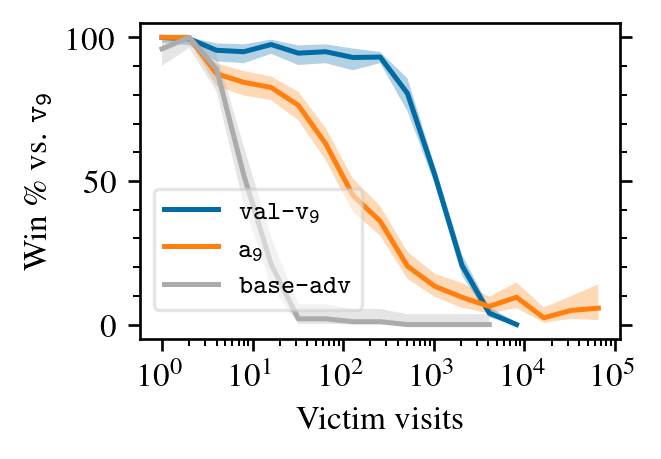

In [92]:
attack_h9_df = utils.parse_sgfs(["/shared/match/ttseng-attack-h9-240314/vs-h9"])
utils.parse_for_match(attack_h9_df, adv_name_regex="attack-h9")

r9_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-19"])
# Only get games against h9
r9_df = filter_df_for_player(r9_df, "h9")
utils.parse_for_match(r9_df, adv_name_regex="r9")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-rs-vs-hs-240119/job-1"])
# Only get games against h9
original_cyclic_df = filter_df_for_player(original_cyclic_df, "h9")
utils.parse_for_match(original_cyclic_df, adv_name_regex="r0-v600")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_h9_df, r"\attackhnineshort{}"),
        #(r9_df[r9_df["victim_visits"] < 60000], r"\attackiter{9}"),
        (r9_df, r"\attackiter{9}"),
        (original_cyclic_df, r"\origcyclicmedium{}"),
    ], 
    r"\defenseiter{9}")
# Move legend and make transparent to increase visibility of plot lines
ax.legend(loc="lower left", bbox_to_anchor=(0, .05)).get_frame().set_alpha(0.5)
fig.savefig("vs-visits-h9.pgf", backend="pgf")
visits_figs[1] = (fig, ax)

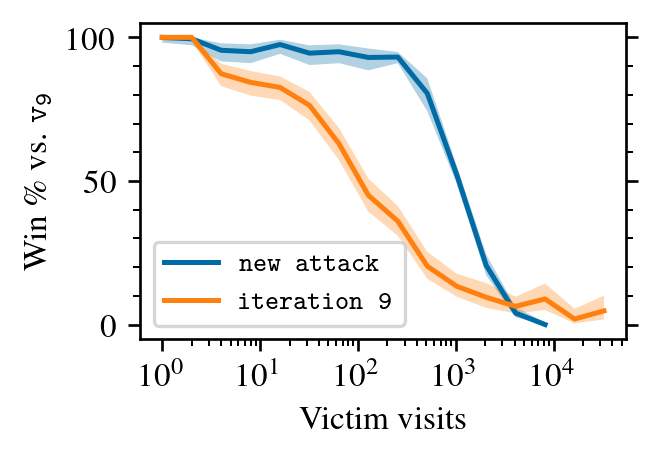

In [30]:
fig, ax = plot_victim_visit_sweep(
    [
        (attack_h9_df, r"\texttt{new attack}"),
        (r9_df[r9_df["victim_visits"] < 60000], r"\texttt{iteration 9}"),
    ], 
    r"\defenseiter{9}")

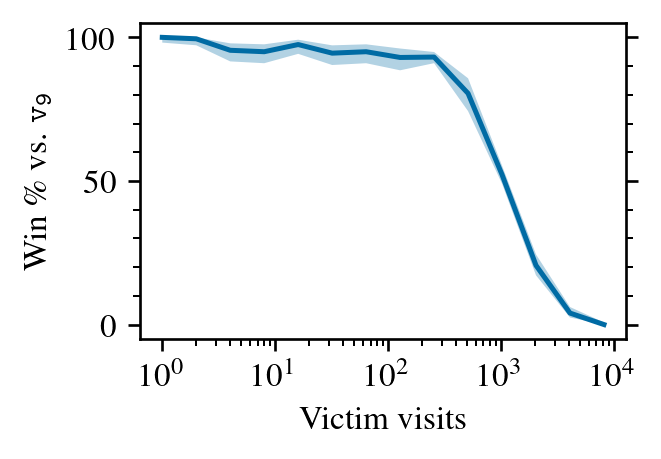

In [31]:
fig, ax = plot_victim_visit_sweep(
    [
        (attack_h9_df, r"\attackhnine{}"),
    ], 
    r"\defenseiter{9}")

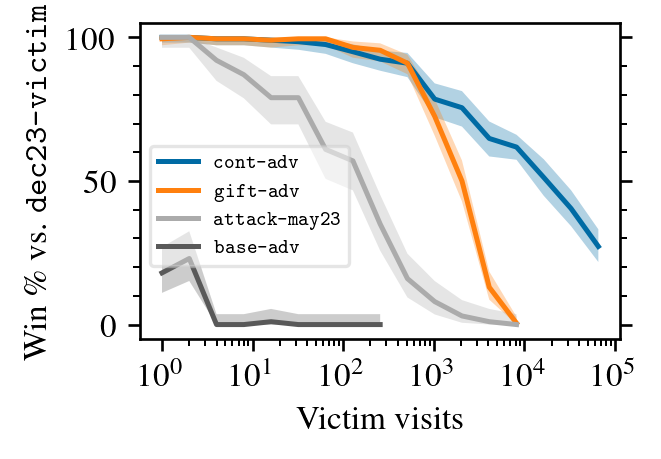

In [93]:
cont_df = utils.parse_sgfs(
    [
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-upto-v4096",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v8192-and-b60",
        "/shared/match/ttseng-cont-vs-b18-s8527m-240311/s630m-v16k-to-65k",
    ]
)
cont_df = filter_df_for_player(cont_df, "b18")
utils.parse_for_match(cont_df, adv_name_regex="cont")

ko_df = utils.parse_sgfs(["/shared/match/ttseng-attack-b18-240417/victim-visits"])
utils.parse_for_match(ko_df, adv_name_regex="attack-b18")

cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-cont-vs-b18-s8527m-240311/cyclic"])
utils.parse_for_match(cyclic_df, adv_name_regex="r0-v600")

attack_b60_df = utils.parse_sgfs(["/shared/match/ttseng-cont-vs-b18-s8527m-240311/attack-b60"])
utils.parse_for_match(attack_b60_df, adv_name_regex="attack-b60")

fig, ax = plot_victim_visit_sweep(
    [
        (cont_df, r"\contadvmedium{}"),
        (ko_df, r"\koadvmedium{}"),
        (attack_b60_df, r"\attackbsixty{}"),
        (cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\dectwentythree{}",
)
ax.legend(loc="lower left", bbox_to_anchor=(0, .2), prop={'size': 6}).get_frame().set_alpha(0.5)
fig.savefig("vs-visits-b18.pgf", backend="pgf")
visits_figs[0] = (fig, ax)

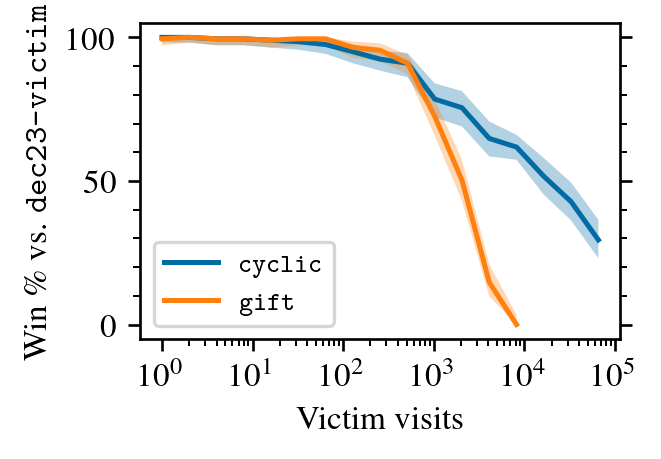

In [33]:
fig, ax = plot_victim_visit_sweep(
    [
        (cont_df, r"\texttt{cyclic}"),
        (ko_df, r"\texttt{gift}")
    ],
    r"\dectwentythree{}",
)

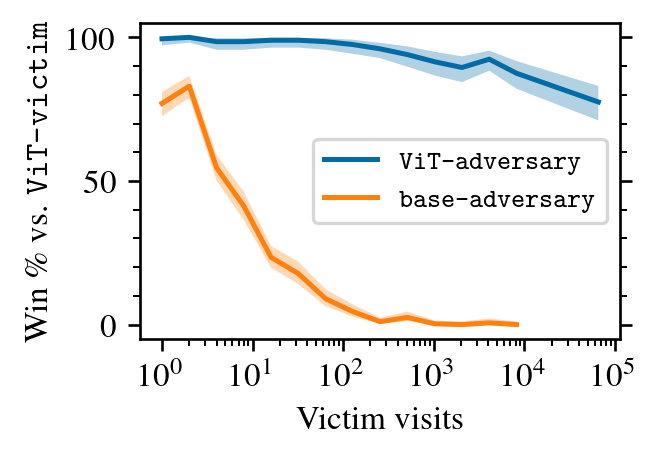

In [34]:
attack_vit_df = utils.parse_sgfs(["/shared/match/ttseng-attack-vit-240311/v1-to-v8192-and-v65536"])
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")

original_cyclic_df = utils.parse_sgfs(["/shared/match/ttseng-vitb16-vs-cyclic"])
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\vitadversary{}"),
        (original_cyclic_df, r"\origcyclic{}"),
    ],
    r"\vitvictim{}",
)
fig.savefig("vs-visits-vit.pgf", backend="pgf")
visits_figs[2] = (fig, ax)

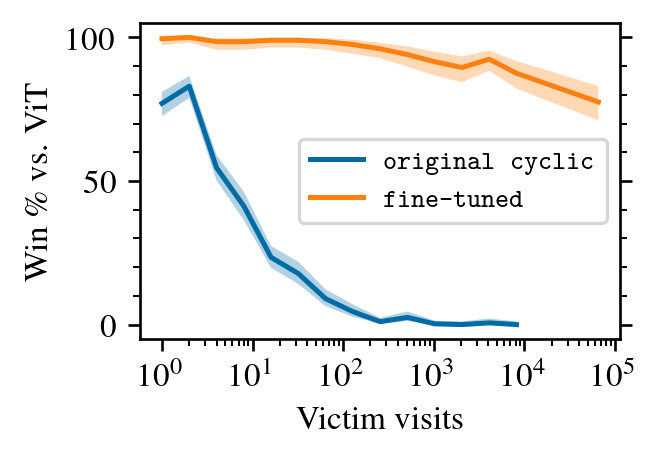

In [35]:
fig, ax = plot_victim_visit_sweep(
    [
        (original_cyclic_df, r"\texttt{original cyclic}"),
        (attack_vit_df, r"\texttt{fine-tuned}"),
    ],
    r"ViT",
)

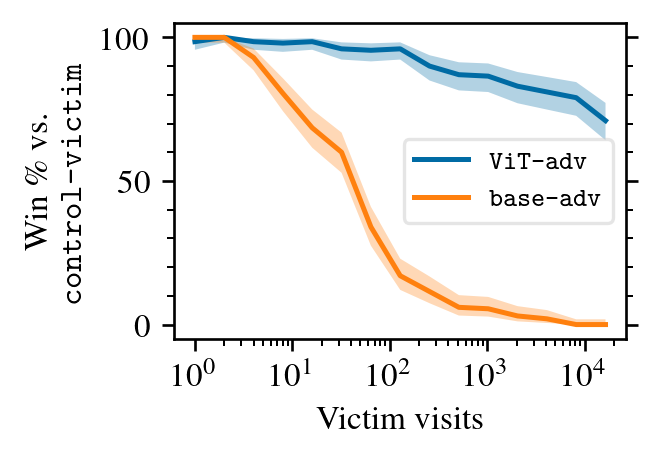

In [43]:
df = utils.parse_sgfs(["/shared/match/attack-b10-240311"])
attack_vit_df = filter_df_for_player(df, "attack-vit")
utils.parse_for_match(attack_vit_df, adv_name_regex="attack-vit")
original_cyclic_df = filter_df_for_player(df, "cyclic")
utils.parse_for_match(original_cyclic_df, adv_name_regex="cyclic")

fig, ax = plot_victim_visit_sweep(
    [
        (attack_vit_df, r"\vitadversarymedium{}"),
        (original_cyclic_df, r"\origcyclicmedium{}"),
    ],
    r"\controlbten{}",
    custom_ylabel="Win \\% vs.\n\\controlbten{}"
)
ax.legend().get_frame().set_alpha(0.5)
fig.savefig("vs-visits-control-b10.pgf", backend="pgf")

/tmp/ipykernel_538319/3287364438.py:70: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


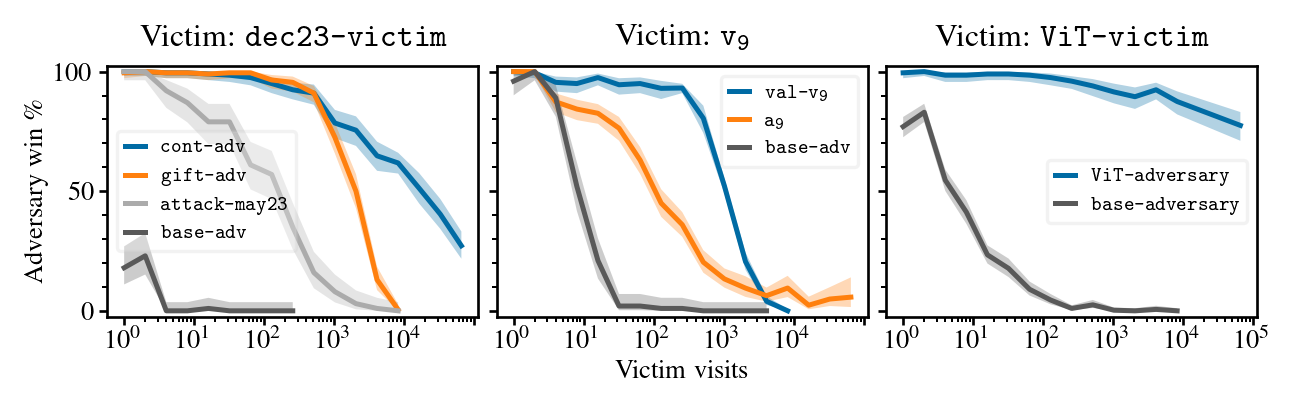

In [94]:
# Combine the main figures into one row, to save space in
# body of the paper
orig_figsize = plt.rcParams['figure.figsize']
one_col_width = orig_figsize[0] / 0.48
extra_style = {
    "figure.figsize": (one_col_width, orig_figsize[1]),
    "font.size": 8,
    "legend.fontsize": 6,
    "axes.labelpad": 2,
    "ytick.right": False,
}
for c in ["x", "y"]:
    extra_style.update({
        f"{c}tick.major.size": 2.4,
        f"{c}tick.minor.size": 1.5,
        f"{c}tick.major.pad": 1.5,
        f"{c}tick.minor.pad": 1.4,
        f"{c}tick.minor.visible": True,
    })
    
with plt.style.context(extra_style):
    fig, axs = plt.subplots(1, 3, sharey=True)
    for i, (ax, (_, old_ax)) in enumerate(zip(axs, visits_figs)):
        confidence_intervals = [ x for x in old_ax.get_children() if isinstance(x, matplotlib.collections.PolyCollection) ]
        for line, ci in zip(old_ax.get_lines(), confidence_intervals):
            label = line.get_label()
            is_base_adv = "origcyclic" in label
            # Give origcyclic the same color across all plots for consistency
            color = COLORS[3] if "origcyclic" in label else line.get_color() 
            
            xs, ys = line.get_data()
            ax.plot(xs, ys, label=line.get_label(), color=color)
            
            ci_polygon = ci.get_paths()[0].vertices
            # CI is a polygon, first tracing left-to-right along the bottom of the CI
            # and then right-to-left along the top of the CI, with a few duplicate points
            # at the extremal x points.
            low_ci = ci_polygon[:len(ci_polygon) // 2]
            xs = low_ci[:, 0]
            low_ys = low_ci[:, 1]
            high_ci = ci_polygon[-len(xs):][::-1]
            assert(np.array_equal(high_ci[:, 0], xs))
            high_ys = high_ci[:, 1]
            ax.fill_between(xs, low_ys, high_ys, facecolor=color, alpha=ci.get_alpha())

        victim = old_ax.get_ylabel().removeprefix("Win \% vs. ")
        ax.set_title(f"Victim: {victim}")
        ax.set_xscale("log")
        ax.set_ylim(-2.5, 102.5)
        ax.legend(handlelength=1).get_frame().set_alpha(0.25)

        # Force more major x-ticks
        _, max_x = ax.get_xlim()
        max_x_tick_log = int(np.floor(np.log10(max_x)))
        ax.set_xticks(np.logspace(0, max_x_tick_log, max_x_tick_log + 1))
        if i < len(axs) - 1:
            # Cut off last x-tick label because it crowds the first x-tick
            # of the next plot to its right.
            labels = [label.get_text() for label in ax.get_xticklabels()]
            labels[-1] = ''
            ax.set_xticklabels(labels)
        
        force_minor_ticks(ax)
        utils.filter_x_minor_ticks(ax)

    axs[0].set_ylabel("Adversary win \%")
    axs[1].set_xlabel("Victim visits")
    

fig.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig("vs-visits-combined.pgf", backend="pgf")